In [1]:
import os

# List all files in the dataset directory
base_path = '/kaggle/input/cleaneddata/cleaned_train_copy.csv'

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the training data
dataset = pd.read_csv(base_path)
dataset.head(5)

,id,Basic_Demos-Age,Basic_Demos-Sex,age_group,CGAS_Score,Physical-BMI,BIA_Activity_Level,Fitness_Combined_Score,Physical_Composite_Index,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,Child,51.000000,16.877316,2.0,0.200000,0.184805,64.4,3.0,2.0
1,000fd460,9,0,Early Teen,65.156829,14.035590,2.0,0.400000,0.178587,64.0,0.0,0.0
2,00105258,10,1,Early Teen,65.156829,19.131648,3.0,0.583126,0.193319,54.0,2.0,0.0
3,00115b9f,9,0,Early Teen,71.000000,18.292347,3.0,0.400000,0.190185,45.0,0.0,1.0
4,001f3379,13,1,Teen,50.000000,22.279952,2.0,0.400000,0.217322,56.0,0.0,1.0


In [2]:
# Drop a column by its name
dataset.drop(['age_group','id'], axis=1, inplace=True)

Accuracy: 0.5824175824175825
Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      1.00      0.74       318
         1.0       0.00      0.00      0.00       146
         2.0       0.00      0.00      0.00        75
         3.0       0.00      0.00      0.00         7

    accuracy                           0.58       546
   macro avg       0.15      0.25      0.18       546
weighted avg       0.34      0.58      0.43       546

Confusion Matrix:
 [[318   0   0   0]
 [146   0   0   0]
 [ 75   0   0   0]
 [  7   0   0   0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


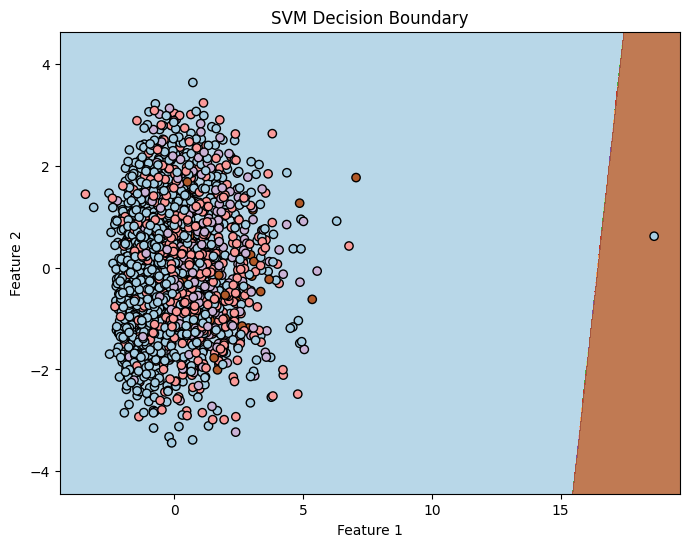

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    accuracy_score,
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Simulated dataset loading (replace with actual dataset)
X, y = dataset.drop(columns=['sii']), dataset['sii']  # Replace 'sii' with target column
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42, stratify=y)

# Convert y_train and y_test to binary (-1, 1) for hinge loss
class_labels = np.unique(y)
y_train_bin = label_binarize(y_train, classes=class_labels) * 2 - 1  # Map 0, 1, 2 -> -1, 1

# Initialize weights and bias
n_features = X_train.shape[1]
n_classes = len(class_labels)
weights = np.zeros((n_classes, n_features))
bias = np.zeros(n_classes)

# Hyperparameters
C = 1  # Regularization strength
learning_rate = 0.001
n_epochs = 1000

# SVM Objective Function
def hinge_loss(X, y, w, b):
    margins = y * (np.dot(X, w.T) + b)
    hinge = np.maximum(0, 1 - margins)
    return hinge

def svm_train(X, y, weights, bias, C, n_epochs, lr):
    for epoch in range(n_epochs):
        for i in range(X.shape[0]):
            for cls in range(len(class_labels)):
                margin = y[i, cls] * (np.dot(X[i], weights[cls]) + bias[cls])
                if margin < 1:  # Misclassified point
                    weights[cls] -= lr * (2 * weights[cls] - C * y[i, cls] * X[i])
                    bias[cls] += lr * C * y[i, cls]
                else:  # Correctly classified
                    weights[cls] -= lr * 2 * weights[cls]
    return weights, bias

# Train SVM model
weights, bias = svm_train(X_train, y_train_bin, weights, bias, C, n_epochs, learning_rate)

# Predict function
def svm_predict(X, weights, bias):
    scores = np.dot(X, weights.T) + bias
    return np.argmax(scores, axis=1)

# Predictions
y_pred = svm_predict(X_test, weights, bias)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualizations
def plot_decision_boundary(X, y, weights, bias):
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = svm_predict(np.c_[xx.ravel(), yy.ravel()], weights, bias)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.title("SVM Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# For visualization, reduce features to 2D using PCA or t-SNE
from sklearn.decomposition import PCA
X_train_2d = PCA(n_components=2).fit_transform(X_train)
plot_decision_boundary(X_train_2d, y_train, weights[:, :2], bias)
